In [1]:
import json
import numpy as np
from scipy.ndimage.measurements import label
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import librosa, librosa.display
import math
import operator
import tensorflow as tf

In [2]:
DATASET_PATH = "../music_data/data.json"

In [3]:
# load data
with open(DATASET_PATH, "r") as fp:
    data = json.load(fp)

    # convert lists to numpy arrays
    inputs = np.array(data["mfcc"])
    labels = np.array(data["labels"])
    genres = data["mapping"]

In [4]:
# split the data into training and test sets
inputs_train, inputs_test, labels_train, labels_test = train_test_split(inputs, labels, test_size=0.3)

In [5]:
# build the network architecture
model = keras.Sequential([
    # input layer
    keras.layers.Flatten(input_shape=(inputs.shape[1], inputs.shape[2])),

    # 1st hidden layer
    keras.layers.Dense(512, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.3),

    # 2nd hidden layer
    keras.layers.Dense(256, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.3),

    # 3rd hidden layer
    keras.layers.Dense(64, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.3),

    # output layer
    keras.layers.Dense(10, activation="softmax")
])

In [6]:
# compile network
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 1690)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               865792    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                16448     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0

In [8]:
# save trained model
checkpoint_path = "../extra_training/dense_test.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [11]:
# train network
history = model.fit(inputs_train, labels_train, 
            validation_split=0.2,
            epochs=20,
            batch_size=32,
            callbacks=[cp_callback])

Epoch 1/20
175/175 [==============================] - 1s 7ms/step - loss: 2.3984 - accuracy: 0.4678 - val_loss: 2.4376 - val_accuracy: 0.4707

Epoch 00001: saving model to ../extra_training\dense_test.ckpt
Epoch 2/20
175/175 [==============================] - 1s 8ms/step - loss: 2.3571 - accuracy: 0.4742 - val_loss: 2.4489 - val_accuracy: 0.4671

Epoch 00002: saving model to ../extra_training\dense_test.ckpt
Epoch 3/20
175/175 [==============================] - 1s 8ms/step - loss: 2.3176 - accuracy: 0.4858 - val_loss: 2.3792 - val_accuracy: 0.4836

Epoch 00003: saving model to ../extra_training\dense_test.ckpt
Epoch 4/20
175/175 [==============================] - 1s 8ms/step - loss: 2.3146 - accuracy: 0.4876 - val_loss: 2.3998 - val_accuracy: 0.4857

Epoch 00004: saving model to ../extra_training\dense_test.ckpt
Epoch 5/20
175/175 [==============================] - 1s 7ms/step - loss: 2.2638 - accuracy: 0.4990 - val_loss: 2.3522 - val_accuracy: 0.4686

Epoch 00005: saving model to ../e

In [12]:
# evaluate on the test set
test_loss, test_accuracy = model.evaluate(inputs_test, labels_test, verbose=1)
print("Accuracy on test set is", test_accuracy)

94/94 [==============================] - 0s 3ms/step - loss: 2.1229 - accuracy: 0.5192
Accuracy on test set is 0.5191730856895447


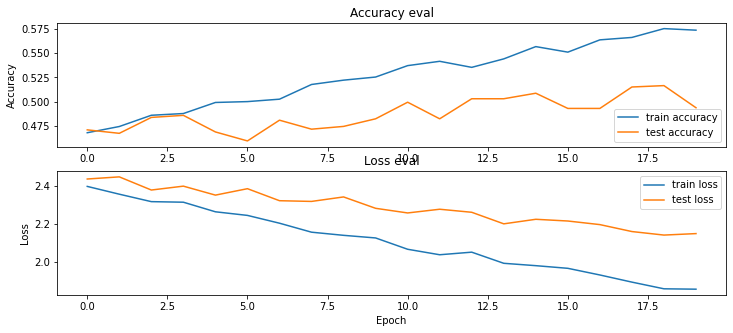

In [13]:
# plot accuracy and error over the epochs
_, axs = plt.subplots(2, figsize=(12, 5))

# create the accuracy subplot
axs[0].plot(history.history["accuracy"], label="train accuracy")
axs[0].plot(history.history["val_accuracy"], label="test accuracy")
axs[0].set_ylabel("Accuracy")
axs[0].legend(loc="lower right")
axs[0].set_title("Accuracy eval")

# create the error subplot
axs[1].plot(history.history["loss"], label="train loss")
axs[1].plot(history.history["val_loss"], label="test loss")
axs[1].set_ylabel("Loss")
axs[1].set_xlabel("Epoch")
axs[1].legend(loc="upper right")
axs[1].set_title("Loss eval")

plt.show()

In [14]:
# test prediction
SONG_NO = 102
inputs_test[SONG_NO].shape
reshaped = inputs_test[SONG_NO][np.newaxis, ...]

prediction = model.predict(reshaped)
predicted_index = np.argmax(prediction)
print("Expected index: {}, Predicted index: {}".format(labels_test[SONG_NO], predicted_index))
print("Predicted genre of the audio file is:", genres[predicted_index])

Expected index: 6, Predicted index: 6
Predicted genre of the audio file is: metal


In [15]:
# load a custom song
file = "../music_files/matt.wav"
data, sr = librosa.load(file) # data = sr * time (ex. 22050 * 30sec of data in data array)

In [16]:
# calculate the track duration in sec
track_duration = math.floor(data.shape[0]/sr)
print(track_duration, "seconds")

694 seconds


In [17]:
# data for preprocessing the file (must be same as the trained files)
NUM_SEGMENT = track_duration//3     # cuts the track to segments
N_MFCC=13
N_FFT=2048                          # no. of samples per STFT window (length of the windowed signal)
HOP_LENGTH=512                      # number of audio samples between adjancent STFT columns
NUM_SAMPLES_PER_SEGMENT = 66150

In [18]:
# processing file for prediction
prediction_mfcc = []
for s in range(NUM_SEGMENT):
    start_sample = NUM_SAMPLES_PER_SEGMENT * s
    end_sample = start_sample + NUM_SAMPLES_PER_SEGMENT

    mfcc = librosa.feature.mfcc(data[start_sample:end_sample], sr=sr, n_mfcc=N_MFCC, n_fft=N_FFT, hop_length=HOP_LENGTH)
    mfcc = mfcc.T

    # store MFCC for segment
    prediction_mfcc.append(mfcc.tolist())
prediction_mfcc = np.array(prediction_mfcc)

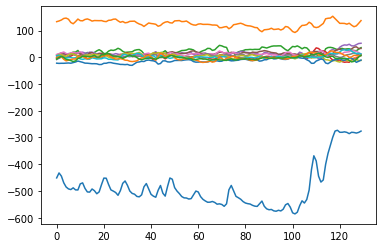

In [19]:
prediction_mfcc[4].shape
plt.plot(prediction_mfcc[4])
plt.show()

In [20]:
# dict for storing multiple genre values with count
predicted_values = {}
for i in range(prediction_mfcc.shape[0]):
    prediction = model.predict(prediction_mfcc[i][np.newaxis, ..., np.newaxis])
    predicted_index = np.argmax(prediction)
    predicted_values[genres[predicted_index]] = predicted_values.get(genres[predicted_index], 0) + 1

In [21]:
# pulling the genre with max occurences in dict and printing the predicted value
predicted_genre = max(predicted_values.items(), key=operator.itemgetter(1))[0]
print(f"Your song is predicted to be of a {predicted_genre} genre.")

Your song is predicted to be of a jazz genre.


In [22]:
# give % of all genres the song is predicted to be
sum_all_values = sum(predicted_values.values())
print("Predicted genre percentages:")
for k, v in predicted_values.items():
    print(f"\t{k}: {round(v/sum_all_values*100, 2)}%")

Predicted genre percentages:
	hiphop: 0.43%
	jazz: 27.71%
	classical: 18.18%
	blues: 2.6%
	country: 19.48%
	reggae: 6.93%
	rock: 1.3%
	disco: 7.36%
	pop: 16.02%


In [20]:
# waveform
# plt.figure(figsize=(12, 5))
# librosa.display.waveplot(data, sr=sr)
# plt.xlabel("Time")
# plt.ylabel("Amplitude")
# plt.show()

In [21]:
# fft -> spectrum
# fft = np.fft.fft(data)
# magnitude = np.abs(fft)
# frequency = np.linspace(0 , sr, len(magnitude))

# left_frequency = frequency[:int(len(frequency)/2)]
# left_magnitude = magnitude[:int(len(frequency)/2)]

# plt.figure(figsize=(12, 5))
# plt.plot(left_frequency, left_magnitude)
# plt.xlabel("Frequency")
# plt.ylabel("Magnitude")
# plt.show()

In [22]:
# stft -> spectogram          
# stft = librosa.core.stft(data, hop_length=HOP_LENGTH, n_fft=N_FFT)
# spectogram = np.abs(stft)

# log_spectogram = librosa.amplitude_to_db(spectogram)

# plt.figure(figsize=(12, 5))
# librosa.display.specshow(log_spectogram, sr=sr, hop_length=HOP_LENGTH)
# plt.xlabel("Time")
# plt.ylabel("Frequency")
# plt.colorbar()
# plt.show()

In [23]:
# stft.shape
# plt.figure(figsize=(12, 5))
# plt.plot(stft)
# plt.show()

In [24]:
# MFCC
# MFCCs = librosa.feature.mfcc(data, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mfcc=13)

# plt.figure(figsize=(12, 5))
# librosa.display.specshow(MFCCs, sr=sr, hop_length=HOP_LENGTH)
# plt.xlabel("Time")
# plt.ylabel("MFCC")
# plt.colorbar()
# plt.show()

In [25]:
# Fourier spectogram
# plt.figure(num=None, figsize=(20, 3))
# plt.subplot(111)
# plt.title('More common (Fourier) spectogram')
# plt.specgram(data, Fs=sr)
# plt.colorbar()
# plt.show()